In [ ]:
# Dataset Link -https://data.mendeley.com/datasets/663j22s43c/3

!pip install 'tensorflow[and-cuda]'
!pip install numpy pandas matplotlib scikit-learn pillow

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

# dataset path
dataset_path = "./dataset"

2025-07-10 15:51:14.230226: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 15:51:14.243047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752142874.256603  507597 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752142874.260639  507597 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752142874.269929  507597 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Class distribution:
         Class  Number of Images
0        lines               157
1   horizontal               136
2     Vertical               101
3        stain               398
4         hole               281
5  defect free              1666


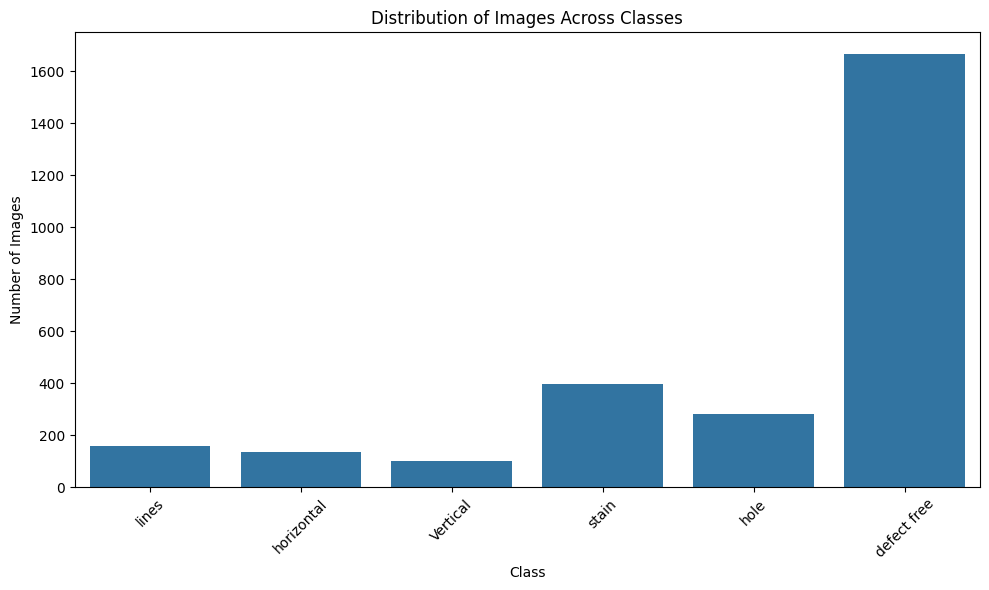

In [ ]:
# 1. Dataset Balance Check
def check_dataset_balance(dataset_path):
    """
    Check the balance of classes in the dataset
    """
    classes = os.listdir(dataset_path)
    class_counts = {}
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    df_counts = pd.DataFrame({
        'Class': list(class_counts.keys()),
        'Number of Images': list(class_counts.values())
    })
    
    print("Class distribution:")
    print(df_counts)
    
    # Visualize the class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Number of Images', data=df_counts)
    plt.title('Distribution of Images Across Classes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return class_counts

class_counts = check_dataset_balance(dataset_path)

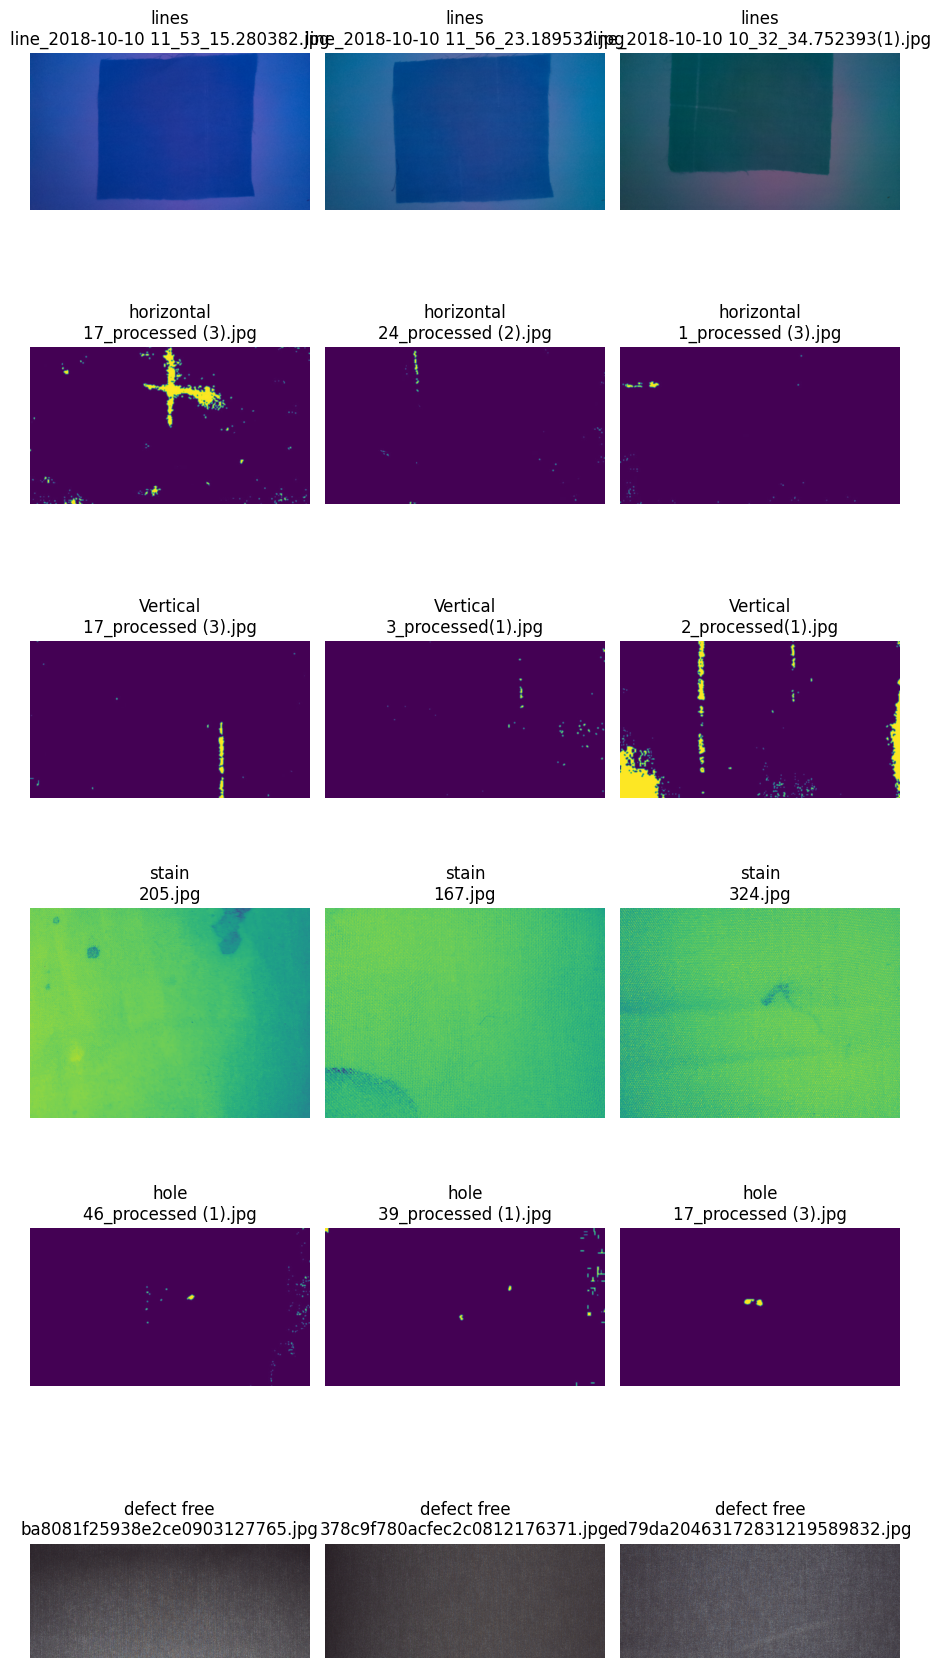

Image Information:
lines: {'shape': (720, 1280, 3), 'dtype': dtype('uint8'), 'min_val': 0, 'max_val': 194}
horizontal: {'shape': (360, 640), 'dtype': dtype('uint8'), 'min_val': 0, 'max_val': 255}
Vertical: {'shape': (360, 640), 'dtype': dtype('uint8'), 'min_val': 0, 'max_val': 255}
stain: {'shape': (1488, 1984), 'dtype': dtype('uint8'), 'min_val': 22, 'max_val': 240}
hole: {'shape': (360, 640), 'dtype': dtype('uint8'), 'min_val': 0, 'max_val': 255}
defect free: {'shape': (1000, 2446, 3), 'dtype': dtype('uint8'), 'min_val': 26, 'max_val': 255}


In [5]:
# 2. Image Exploration
def explore_images(dataset_path, num_samples=1):
    """
    Explore images from each class
    """
    classes = os.listdir(dataset_path)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples*3, len(classes)*3))
    
    image_info = {}
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)[:num_samples]
            
            for j, img_file in enumerate(image_files):
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path)
                img_array = np.array(img)
                
                # Store image information
                if class_name not in image_info:
                    image_info[class_name] = {
                        'shape': img_array.shape,
                        'dtype': img_array.dtype,
                        'min_val': img_array.min(),
                        'max_val': img_array.max(),
                    }
                
                # Plot the image
                if len(classes) > 1:
                    if num_samples > 1:
                        axes[i, j].imshow(img)
                        axes[i, j].set_title(f"{class_name}\n{img_file}")
                        axes[i, j].axis('off')
                    else:
                        axes[i].imshow(img)
                        axes[i].set_title(f"{class_name}\n{img_file}")
                        axes[i].axis('off')
                else:
                    axes[j].imshow(img)
                    axes[j].set_title(f"{class_name}\n{img_file}")
                    axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print image information
    print("Image Information:")
    for class_name, info in image_info.items():
        print(f"{class_name}: {info}")
    
    return image_info

image_info = explore_images(dataset_path, num_samples=3)

In [ ]:
# 3. Data Preprocessing and Loading
def prepare_data(dataset_path, img_height=224, img_width=224, batch_size=32, validation_split=0.2):
    """
    Prepare data for training
    """
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Only rescaling for validation
    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )
    
    # Training dataset
    train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    # Validation dataset
    validation_generator = validation_datagen.flow_from_directory(
        dataset_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, validation_generator

# Set parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_generator, validation_generator = prepare_data(
    dataset_path,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    batch_size=BATCH_SIZE
)

Found 2193 images belonging to 6 classes.
Found 546 images belonging to 6 classes.


In [7]:
# 4. Model Creation - Transfer Learning with MobileNetV2
def create_model(num_classes):
    """
    Create a transfer learning model using MobileNetV2
    """
    # Load the base model
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Get the number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {train_generator.class_indices}")

# Create the model
model = create_model(num_classes)

# Model summary
model.summary()

Number of classes: 6
Class mapping: {'Vertical': 0, 'defect free': 1, 'hole': 2, 'horizontal': 3, 'lines': 4, 'stain': 5}


I0000 00:00:1752142878.459919  507597 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1054 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# 5. Training the Model
def train_model(model, train_generator, validation_generator, epochs=10):
    """
    Train the model using GPU acceleration
    """
    # Create callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    # Add TensorBoard for monitoring
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir="./logs", 
        histogram_freq=1,
        update_freq='epoch'
    )
    
    # Train the model with compatible settings
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=epochs,
        callbacks=[early_stopping, tensorboard_callback]
        # Removed workers and use_multiprocessing parameters
    )
    
    return history

In [18]:
# 6. Evaluation and Visualization
def evaluate_model(model, history, validation_generator):
    """
    Evaluate the model and visualize the results
    """
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate the model on the validation set
    evaluation = model.evaluate(validation_generator)
    print(f"Validation Loss: {evaluation[0]:.4f}")
    print(f"Validation Accuracy: {evaluation[1]:.4f}")
    
    # Predict on validation set
    validation_generator.reset()
    y_pred = model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # True classes
    y_true = validation_generator.classes
    
    # Get class labels
    class_labels = list(validation_generator.class_indices.keys())
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


Found 2193 images belonging to 6 classes.


Found 546 images belonging to 6 classes.
Training the model using GPU acceleration...


/home/cyrixninja/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8937 - loss: 0.2475 - val_accuracy: 0.8711 - val_loss: 0.3568
Epoch 2/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9531 - loss: 0.1017

/home/cyrixninja/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.9531 - loss: 0.1017 - val_accuracy: 0.8652 - val_loss: 0.3568
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8987 - loss: 0.2316 - val_accuracy: 0.8672 - val_loss: 0.4262
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.8594 - loss: 0.2707 - val_accuracy: 0.8613 - val_loss: 0.4201
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8968 - loss: 0.2494 - val_accuracy: 0.8281 - val_loss: 0.4345
Evaluating the model...


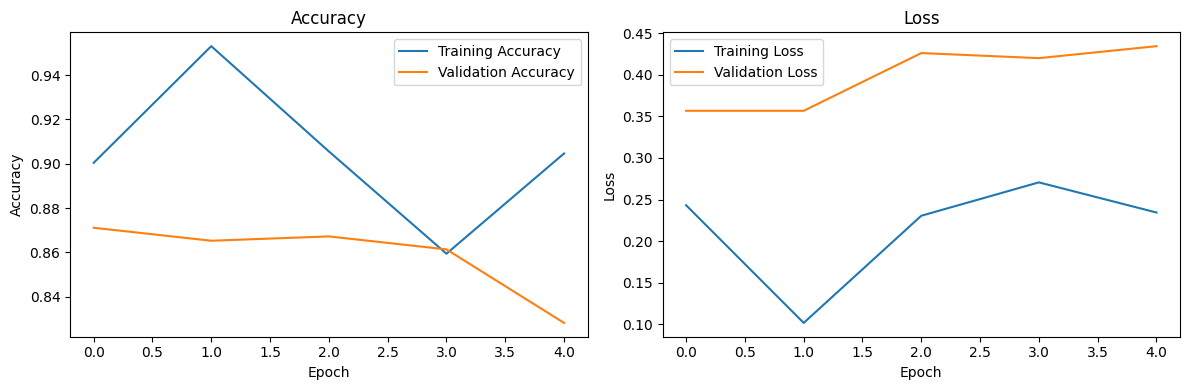

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 671ms/step - accuracy: 0.9311 - loss: 0.2636
Validation Loss: 0.3523
Validation Accuracy: 0.8718
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 669ms/step
Classification Report:
              precision    recall  f1-score   support

    Vertical       0.68      0.75      0.71        20
 defect free       0.92      0.99      0.96       333
        hole       0.56      0.66      0.61        56
  horizontal       0.85      0.81      0.83        27
       lines       1.00      0.19      0.32        31
       stain       0.96      0.82      0.88        79

    accuracy                           0.87       546
   macro avg       0.83      0.71      0.72       546
weighted avg       0.88      0.87      0.86       546



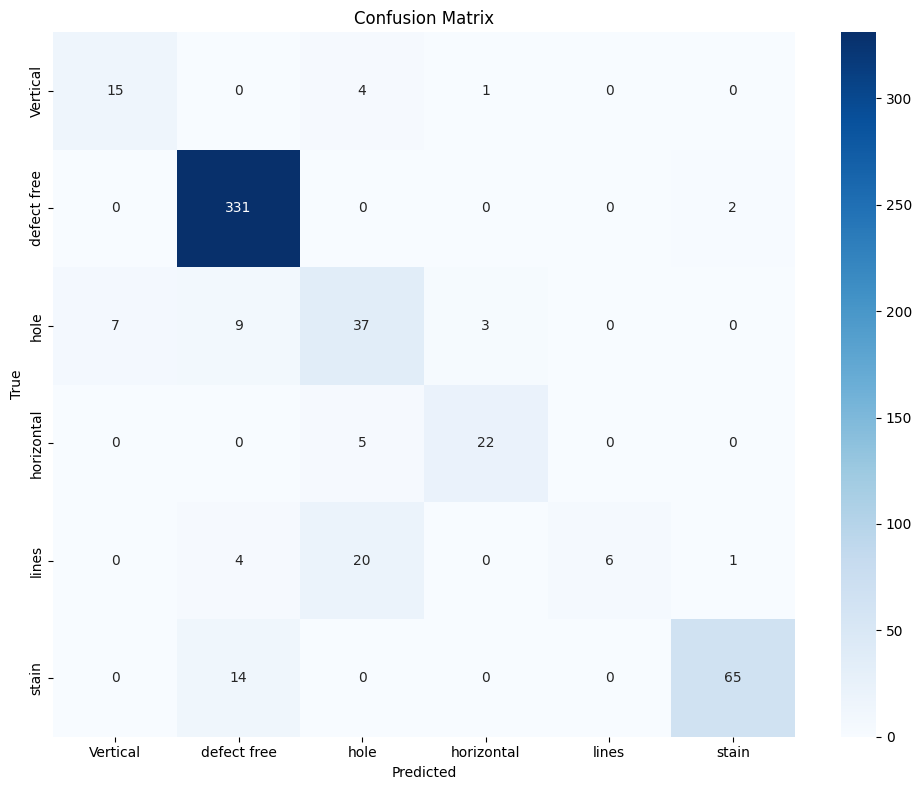

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64  

train_generator, validation_generator = prepare_data(
    dataset_path,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    batch_size=BATCH_SIZE
)
EPOCHS = 50
print("Training the model using GPU acceleration...")
history = train_model(model, train_generator, validation_generator, epochs=EPOCHS)
print("Evaluating the model...")
evaluate_model(model, history, validation_generator)

# Save the model 
model.save('fabric_defect_model_gpu.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted defect class: stain
Confidence: 61.57%


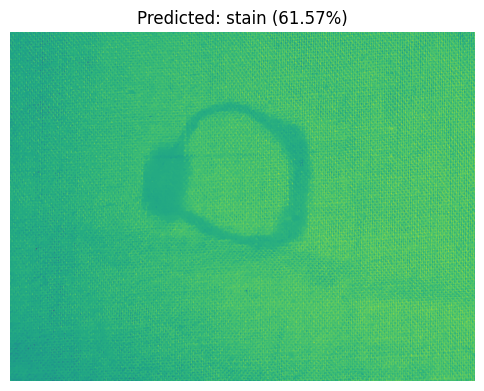

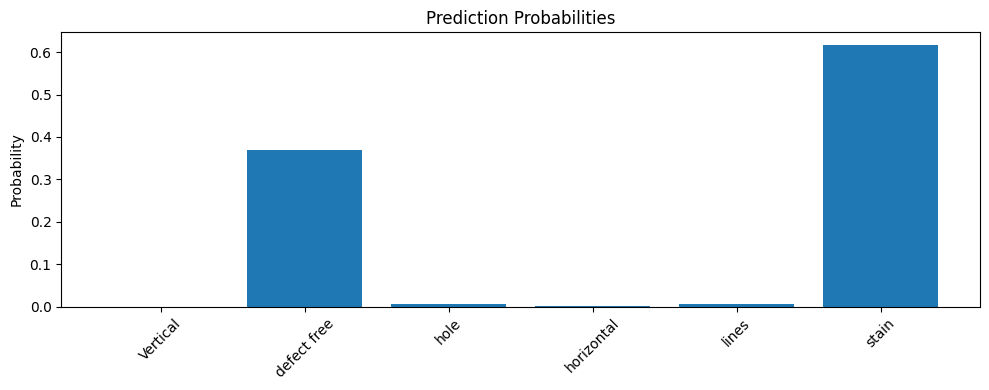

In [ ]:
# 7. Using the Trained Model for Predictions
def load_and_preprocess_image(image_path, img_height=224, img_width=224):
    """
    Load and preprocess a single image for prediction
    """
    # Load the image
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width)
    )
    
    # Convert to array and add batch dimension
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normalize pixel values
    img_array = img_array / 255.0
    
    return img_array

def predict_defect(model, image_path, class_indices):
    """
    Predict the defect class for a single image
    """
    # Preprocess the image
    processed_img = load_and_preprocess_image(image_path)
    
    # Make prediction
    predictions = model.predict(processed_img)
    predicted_class_idx = np.argmax(predictions[0])
    
    # Get the class name from index
    idx_to_class = {v: k for k, v in class_indices.items()}
    predicted_class = idx_to_class[predicted_class_idx]
    confidence = float(predictions[0][predicted_class_idx])
    
    return predicted_class, confidence, predictions[0]

# Load the saved model
loaded_model = tf.keras.models.load_model('fabric_defect_model.h5')

# Example usage with a test image
test_image_path = "./dataset/stain/125.jpg"  

try:
    # Get class indices from the training generator
    class_indices = train_generator.class_indices
    
    # Make prediction
    predicted_class, confidence, all_probabilities = predict_defect(
        loaded_model, test_image_path, class_indices
    )
    
    # Display results
    print(f"Predicted defect class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")
    
    # Display the image with its prediction
    plt.figure(figsize=(6, 6))
    img = plt.imread(test_image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2%})")
    plt.axis('off')
    plt.show()
    
    # Show probabilities for all classes
    plt.figure(figsize=(10, 4))
    classes = list(class_indices.keys())
    plt.bar(classes, all_probabilities)
    plt.title('Prediction Probabilities')
    plt.xticks(rotation=45)
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error making prediction: {e}")
    print("Please make sure the test image path is correct.")

# Function to process multiple images in a folder
def batch_predict_defects(model, folder_path, class_indices):
    """
    Predict defects for all images in a folder
    """
    results = []
    
    # Get all image files
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            pred_class, confidence, _ = predict_defect(model, img_path, class_indices)
            results.append({
                'image': img_file,
                'predicted_class': pred_class,
                'confidence': confidence
            })
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    # Convert to dataframe
    results_df = pd.DataFrame(results)
    return results_df